In [ ]:
%load_ext autoreload
%autoreload 2

In [36]:
from time import time
from classes.systemFactory import SystemFactory
import settings
import pickle
import json
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pandas as pd
from gensim.models import KeyedVectors


warnings.filterwarnings(action='ignore')

In [2]:
system = SystemFactory()
system.build_load_system()
# system.vsm.loadModel('models/VSM/18/model.bin')

In [3]:
system.vsm.model = KeyedVectors.load_word2vec_format('models/VSM/18/model.txt', binary=False)

2022-03-17 12:59:25,212 : INFO : loading projection weights from models/VSM/18/model.txt
/home/roman/Desktop/Mta_Apps/aspect-extraction/venv/lib/python3.9/site-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
2022-03-17 13:00:07,018 : INFO : loaded (291186, 300) matrix from models/VSM/18/model.txt


In [5]:
DATASET = 'data/notebooks_reviews.json'  

In [6]:
# df = pd.read_csv(DATASET)
# df     

In [7]:
df = pd.read_json(DATASET)
text = []
[text.extend(t) for t in df['pros'] + df['cons']]
df = pd.DataFrame(text, columns=['text'])
df

text
0                    Great keyboard
1           Excellent build quality
2      Bright, high-contrast screen
3           Sturdy 360-degree hinge
4     Max speaker volume is just OK
...                             ...
1444                  Durable build
1445  Weak battery life on 4K model
1446                  Fans get loud
1447                Thick and heavy
1448                      Expensive

[1449 rows x 1 columns]

In [8]:
dataset = system.preprocessor.clean(dataset=df['text'][:int(10e5)])
dataset['cleaned'][:10]

[['great', 'keyboard'],
 ['excellent', 'build', 'quality'],
 ['bright', 'highcontrast', 'screen'],
 ['sturdy', '360degree', 'hinge'],
 ['max', 'speaker', 'volume', 'is', 'just', 'ok'],
 ['not', 'powerful', 'macbook', 'air'],
 ['smooth', 'performance', 'for', 'daytoday', 'tasks'],
 ['great', 'battery', 'life'],
 ['full', 'hd', 'screen', 'resolution'],
 ['gunmetalgrey', 'metal', 'construction', 'looks', 'classy']]

## Dataset statistics

### Number of words in reviews

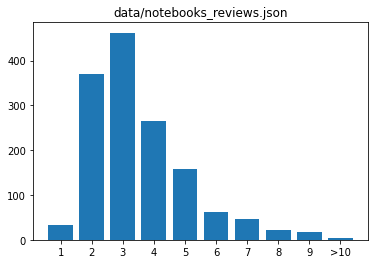

In [9]:
from collections import Counter
import collections
import matplotlib.pyplot as plt
from operator import itemgetter

document_lengths = []
for item in dataset['cleaned']:
    length = len(item)
    if length >= 10:
        document_lengths.append('>10')
    else:
        document_lengths.append(str(length))

w = Counter(document_lengths)
plt.bar(
    [k[0] for k in sorted(w.items())],
    [k[1] for k in sorted(w.items())]
)
plt.title(DATASET)
del document_lengths  

### Relative length of reviews

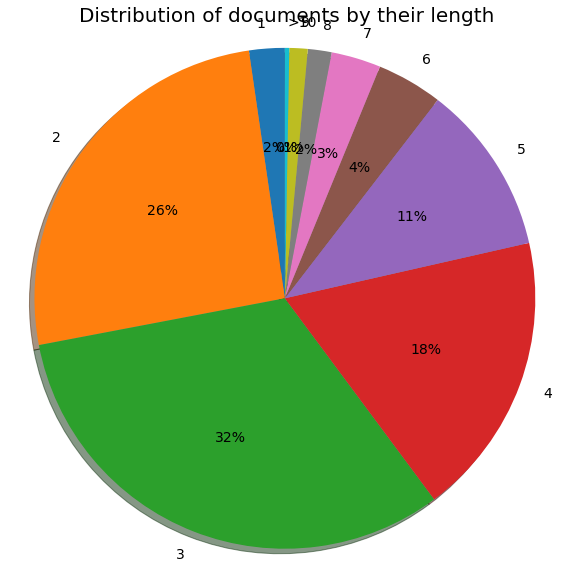

In [10]:
import matplotlib.pyplot as plt

labels = [k[0] for k in sorted(w.items())]
sizes = [k[1] for k in sorted(w.items())]

fig1, ax1 = plt.subplots(figsize=(10,10))
plt.title("Distribution of documents by their length", {'fontsize': 20})
ax1.pie(sizes , labels=labels, autopct='%1.0f%%',
        shadow=True, startangle=90, textprops={'fontsize': 14})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


### Frequency of phrases

In [11]:
phrases_freq = []
for item in dataset['cleaned']:
    phrases_freq.append('_'.join(item))

phrases_freq = Counter(phrases_freq)
w = dict(phrases_freq.most_common(10))

# del phrases_freq, w  

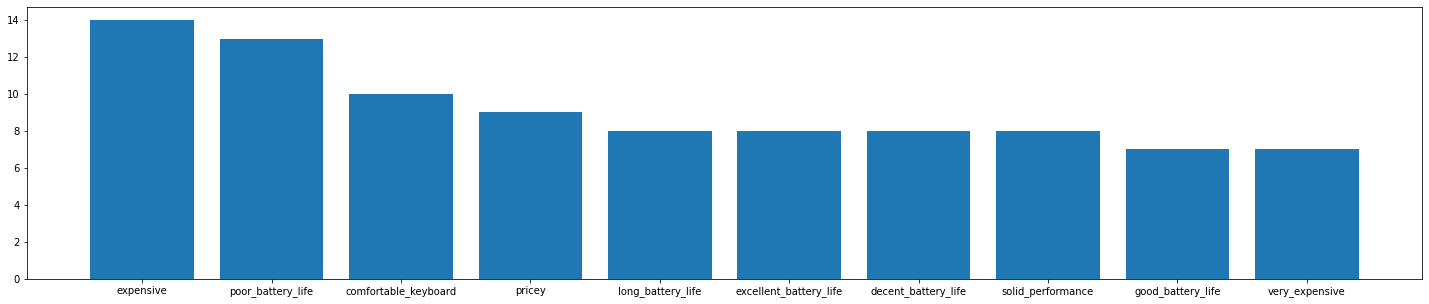

In [12]:
plt.figure(figsize=(25, 5))
plt.bar(
    [k[0] for k in sorted(w.items(), key=lambda x: x[1], reverse=True)], 
    [k[1] for k in sorted(w.items(), key=lambda x: x[1], reverse=True)],
)
plt.show()

## Clusterize

In [13]:
cnt = {}
for idx, item in enumerate(dataset['cleaned']):
    key = '_'.join(item)
    if key not in cnt:
        cnt.update({key: {'count': 1, 'raw': dataset['raw'][idx]}})
    else:
        cnt[key]['count'] += 1

sortedFreq = sorted(list(cnt.items()), key=lambda x: x[1]['count'], reverse=True)
topItems = {'cleaned': [], 'raw': []}
for item in sortedFreq:
    if item[1]['count'] >= 1:
        topItems['cleaned'].append(item[0].split('_'))
        topItems['raw'].append(item[1]['raw'])
del item, key, idx
len(topItems['cleaned'])

1183

In [14]:
LENGTH_THRESHOLD = 4
reviews_to_clusterize = {'cleaned': [], 'raw': []}
tmp_cleaned = set()
for cleaned, raw in zip(topItems['cleaned'], topItems['raw']):
    if (len(cleaned) <= LENGTH_THRESHOLD) and '_'.join(cleaned) not in tmp_cleaned:
        tmp_cleaned.add('_'.join(cleaned))
        reviews_to_clusterize['cleaned'].append(cleaned)
        reviews_to_clusterize['raw'].append(raw)
        
del tmp_cleaned
len(reviews_to_clusterize['raw'])

882

### WCSS

2022-03-17 13:33:37,247 : INFO : Clustrovanie dokumentov zacalo
2022-03-17 13:33:43,404 : INFO : Clustrovanie dokumentov dokoncene.
 Inertia: 296.44858714463345,
 max. rozptyl: 0.05610915594246898
2022-03-17 13:33:43,405 : INFO : Clustrovanie dokumentov zacalo
2022-03-17 13:33:49,972 : INFO : Clustrovanie dokumentov dokoncene.
 Inertia: 268.1891956462176,
 max. rozptyl: 0.06367843251317082
2022-03-17 13:33:49,973 : INFO : Clustrovanie dokumentov zacalo
2022-03-17 13:33:56,718 : INFO : Clustrovanie dokumentov dokoncene.
 Inertia: 233.87863798953103,
 max. rozptyl: 0.0735017953123665
2022-03-17 13:33:56,719 : INFO : Clustrovanie dokumentov zacalo
2022-03-17 13:34:04,803 : INFO : Clustrovanie dokumentov dokoncene.
 Inertia: 205.49475007264226,
 max. rozptyl: 0.0889345768037402


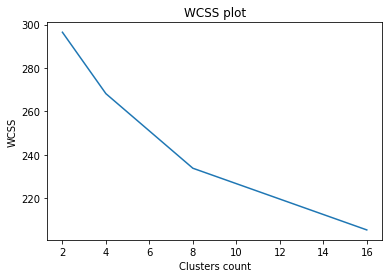

In [39]:
system.clusterizer.get_WCSS(dataset=reviews_to_clusterize, upper_boundary=20)

### Davies Bouldin index

2022-03-17 14:33:10,905 : INFO : Clustrovanie dokumentov zacalo
2022-03-17 14:33:16,956 : INFO : Clustrovanie dokumentov dokoncene.
 Inertia: 296.4485871446335,
 max. rozptyl: 0.05610915594246898
2022-03-17 14:33:17,096 : INFO : Clustrovanie dokumentov zacalo
2022-03-17 14:33:23,314 : INFO : Clustrovanie dokumentov dokoncene.
 Inertia: 281.1965803237364,
 max. rozptyl: 0.06265606572102228
2022-03-17 14:33:23,456 : INFO : Clustrovanie dokumentov zacalo
2022-03-17 14:33:29,894 : INFO : Clustrovanie dokumentov dokoncene.
 Inertia: 268.1891956462176,
 max. rozptyl: 0.06367843251317082
2022-03-17 14:33:30,045 : INFO : Clustrovanie dokumentov zacalo
2022-03-17 14:33:37,131 : INFO : Clustrovanie dokumentov dokoncene.
 Inertia: 256.29424525658106,
 max. rozptyl: 0.06812314681777573
2022-03-17 14:33:37,268 : INFO : Clustrovanie dokumentov zacalo
2022-03-17 14:33:43,909 : INFO : Clustrovanie dokumentov dokoncene.
 Inertia: 246.14138436721453,
 max. rozptyl: 0.06941820556668413
2022-03-17 14:33:4

Best separation: 28 clusters (BDI: 2.4266360561787836)


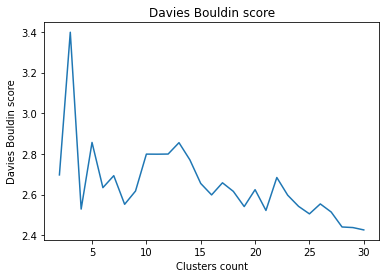

In [47]:
system.clusterizer.get_davies_bouldin_score(dataset=reviews_to_clusterize, upper_boundary=30)

In [44]:
N_CLUSTERS = 13
DIST_METRIC = 'mean'
a = system.clusterizer.clusterize(dataset=reviews_to_clusterize , n_clusters=N_CLUSTERS, dist_metric=DIST_METRIC)

2022-03-17 13:42:22,321 : INFO : Clustrovanie dokumentov zacalo
2022-03-17 13:42:28,920 : INFO : Clustrovanie dokumentov dokoncene.
 Inertia: 213.31497281174723,
 max. rozptyl: 0.09896341313616938


In [46]:
system.clusterizer.save_to_file(path='./output/notebooks_clusters.json', f_format='nn_classifier')